In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import ast

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *
from ModelSelection import *


%matplotlib inline

In [2]:
cup_df = pd.read_csv(
    '../data/ML-CUP23-TR.csv',
    index_col=0,
    comment='#',
    header=None,
    names=['feature_' + str(i+1) for i in range(10)] + ['target_' + str(i+1) for i in range(3)]
)

data_set = cup_df.values
len_data = len(data_set)
np.random.shuffle(data_set)

TR_OUTPUT = 3
TR_INPUT = data_set.shape[1] - TR_OUTPUT
scaler_out = StandardScaler()
scaler_in = StandardScaler()
scaler_in.fit(data_set[:,:TR_INPUT])
scaler_out.fit(data_set[:,TR_INPUT:])

training_len = int(0.8*len_data)

training_set = data_set[:int(training_len)] # Training Set for KFold Cross Validation
test_set = data_set[int(training_len):] # Hold Out Test Set

tr_normalized = np.empty((training_len, TR_OUTPUT + TR_INPUT))
tr_normalized[:,:TR_INPUT] = scaler_in.transform(training_set[:,:TR_INPUT])
tr_normalized[:,TR_INPUT:] = scaler_out.transform(training_set[:,TR_INPUT:])

test_normalized = np.empty((len_data - training_len, TR_OUTPUT + TR_INPUT))
test_normalized[:,:TR_INPUT] = scaler_in.transform(test_set[:,:TR_INPUT])
test_normalized[:,TR_INPUT:] = scaler_out.transform(test_set[:,TR_INPUT:])

In [3]:
def load_obj(path):    
    with open(path, 'r') as file:
        ret = json.load(file)
    for el in ret:
        with open(el['nn_file_name'], 'r') as file:
                el['model'] = NeuralNetwork.fromJSON(file.read())
    return ret
            
def save_obj(obj, path):
    for i in obj:
        with open(i['nn_file_name'], 'w+') as file:
            file.write(i['model'].toJSON())
        i['model'] = None
    json.dump(obj, path, default=str)

In [ ]:
def remove_useless_val(x):
    a =['learning_rate', 'lr_decay_tau', 'alpha_momentum']
    b =['adamax_learning_rate', 'exp_decay_rate_1', 'exp_decay_rate_2']
    if x['adamax']:
        for i in a:
            if i in x.keys():
                x[i] = None
    else:
        for i in b:
            if i in x.keys():
                x[i] = None   
    return x

In [21]:
columns_order = ['topology', 'stats',
 'batch_size',
 'min_epochs',
 'max_epochs',
 'patience',
 'error_increase_tolerance',
 'lambda_tikhonov',
 
 'learning_rate',
 'alpha_momentum',
 'lr_decay_tau',
 
 'adamax',
 'adamax_learning_rate',
 'exp_decay_rate_1',
 'exp_decay_rate_2',
 
 'mean_mean_euclidean_error',
 'mean_mean_squared_error',
 'var_mean_euclidean_error',
 'var_mean_squared_error',
 'mean_best_validation_training_error']

In [22]:
results_files = ['1l_sigmoid_2.csv', '1l_tanh_2.csv']
topologies = ['32_sigmoid', '32_tanh']
folder = '../data/gs_data/'
topologies_dict = {}
gs_results = []
for i, f in enumerate(results_files):
    if os.path.isfile(folder+ f):
        dummy = pd.read_csv(folder + f)
        topologies_dict[topologies[i]] = ast.literal_eval(dummy['topology'][0])
        dummy['topology'] = topologies[i]
        
        gs_results.append(dummy)
    


orig_df = pd.concat(gs_results)
orig_df.head(1)

,adamax,alpha_momentum,batch_size,error_increase_tolerance,lambda_tikhonov,learning_rate,lr_decay_tau,max_epochs,min_epochs,patience,topology,stats,mean_mean_euclidean_error,mean_mean_squared_error,var_mean_euclidean_error,var_mean_squared_error,mean_best_validation_training_error
0,False,0.5,20,0.00001,0.000001,0.2,175,600,100,5,32_sigmoid,"{'lr_decay_tau': 7000.0, 'retraing_es_error': ...",0.133066,0.024515,0.000131,0.000023,0.019906


In [23]:
columns_order = [x for x in columns_order if x in orig_df.columns]
orig_df = orig_df[columns_order]

order_by = 'mean_mean_euclidean_error'
orig_df.sort_values(by=[order_by], inplace=True)
orig_df = orig_df.reset_index(drop=True)
gs_results = orig_df.drop(['stats'], axis=1)

In [25]:
#warnings.simplefilter(action='ignore', category=FutureWarning)
gs_results = gs_results.apply(remove_useless_val, axis=1)
#warnings.simplefilter(action='default', category=FutureWarning)
for i in gs_results.columns[1:]:
    gs_results[i] = gs_results[i].astype(float)

In [26]:
numerical_col = list(gs_results.columns)
numerical_col.remove('topology')
st_opt_col = ['learning_rate','lr_decay_tau','alpha_momentum']
adamax_opt_col = ['adamax','adamax_learning_rate','exp_decay_rate_1','exp_decay_rate_2']
metrics_col = [x for x in gs_results.columns if x.startswith(('var', 'mean'))]
general_col = [item for item in list(gs_results.columns) if item not in st_opt_col and item not in metrics_col and item not in adamax_opt_col]
tr_input_col = [item for item in list(gs_results.columns) if item not in metrics_col]

In [27]:
error_treshold = 10
gs_results_clean = gs_results.loc[(gs_results['mean_mean_euclidean_error'].notna()) & (gs_results['mean_mean_euclidean_error'] < error_treshold)].copy()


gs_results_clean = gs_results_clean.reset_index(drop=True)
gs_results_clean.style.background_gradient(cmap='Blues')

,topology,batch_size,min_epochs,max_epochs,patience,error_increase_tolerance,lambda_tikhonov,learning_rate,alpha_momentum,lr_decay_tau,adamax,mean_mean_euclidean_error,mean_mean_squared_error,var_mean_euclidean_error,var_mean_squared_error,mean_best_validation_training_error
0,32_sigmoid,20.000000,100.000000,600.000000,5.000000,0.000010,0.000001,0.100000,0.900000,175.000000,0.000000,0.129708,0.023409,0.000008,0.000000,0.017754
1,32_sigmoid,20.000000,100.000000,600.000000,5.000000,0.000010,0.000001,0.050000,0.900000,175.000000,0.000000,0.130006,0.024790,0.000230,0.000036,0.019081
2,32_sigmoid,20.000000,100.000000,600.000000,5.000000,0.000010,0.000010,0.100000,0.900000,175.000000,0.000000,0.132110,0.023512,0.000034,0.000005,0.018145
3,32_sigmoid,20.000000,100.000000,600.000000,5.000000,0.000010,0.000010,0.100000,0.900000,125.000000,0.000000,0.132444,0.024434,0.000016,0.000004,0.019525
4,32_sigmoid,20.000000,100.000000,600.000000,5.000000,0.000010,0.000001,0.100000,0.900000,125.000000,0.000000,0.132890,0.023954,0.000010,0.000003,0.017499
5,32_sigmoid,20.000000,100.000000,600.000000,5.000000,0.000010,0.000001,0.200000,0.500000,175.000000,0.000000,0.133066,0.024515,0.000131,0.000023,0.019906
6,32_sigmoid,20.000000,100.000000,600.000000,5.000000,0.000010,0.000001,0.050000,0.900000,200.000000,0.000000,0.133445,0.024427,0.000005,0.000002,0.017568
7,32_sigmoid,20.000000,100.000000,600.000000,5.000000,0.000010,0.000010,0.200000,0.500000,175.000000,0.000000,0.134108,0.023956,0.000047,0.000013,0.019624
8,32_sigmoid,20.000000,100.000000,600.000000,5.000000,0.000010,0.000010,0.050000,0.900000,200.000000,0.000000,0.137914,0.024818,0.000217,0.000028,0.018757
9,32_tanh,20.000000,100.000000,600.000000,5.000000,0.000010,0.000001,0.100000,0.750000,175.000000,0.000000,0.139580,0.026888,0.000059,0.000012,0.020947


In [28]:
minmaxsc = MinMaxScaler()
std_gs_results_clean = pd.DataFrame(data=minmaxsc.fit_transform(gs_results_clean[numerical_col]), columns=numerical_col)

In [29]:

def plot_gs(df, title):
    
    maps = {'adamax optimizer': adamax_opt_col,
            'standard optimizer': st_opt_col,
            'general': general_col,
            'metrics': metrics_col,
    }
    # groups and trace visibilities
    group = []
    vis = []
    visList = []
    for m in maps.keys():
        for col in numerical_col:
            if col in maps[m]:
                vis.append(True)
            else:
                vis.append(False)
        group.append(m)
        visList.append(vis)
        vis = []

    
    fig = px.line(df, title=title)
    #fig.update_layout(xaxis_range=[0, last_index])
    fig.update_yaxes(showticklabels=False)
    fig.update_traces(mode="markers+lines", hovertemplate=None)
    fig.update_layout(hovermode="x unified")

    # buttons for each group
    buttons = []
    for i, g in enumerate(group):
        button =  dict(label=g,
                    method = 'restyle',
                        args = ['visible',visList[i]])
        buttons.append(button)

    buttons = [{'label': 'all',
                    'method': 'restyle',
                    'args': ['visible', [True, True, True, True, True, True]]}] + buttons
    fig.update_layout(
        updatemenus=[
            dict(
            type="dropdown",
            direction="down",
            buttons = buttons)
        ],
    )   

    return fig

In [30]:
plot_gs(std_gs_results_clean.iloc[:20], 'GridSearch normalized values')

In [31]:
plot_gs(gs_results_clean[numerical_col].iloc[:20], 'GridSearch values')

In [32]:
#  best performance
n_best_fem = 3
sorting_values_col = ['mean_mean_euclidean_error', 'mean_mean_squared_error', 'mean_best_validation_training_error']
interesting_index = []
for i in topologies_dict:
    for col in sorting_values_col:
        interesting_index += list(orig_df.loc[orig_df['topology'] == i].sort_values([col]).head(n_best_fem).index)
    #interesting_index.insert(orig_df.loc[orig_df['topology'] == i].sort_values(['mean_mean_euclidean_error']).head(n_best_fem).index)
#interesting_index = list(orig_df['topology'].drop_duplicates().index)
orig_df.iloc[interesting_index]

,topology,stats,batch_size,min_epochs,max_epochs,patience,error_increase_tolerance,lambda_tikhonov,learning_rate,alpha_momentum,lr_decay_tau,adamax,mean_mean_euclidean_error,mean_mean_squared_error,var_mean_euclidean_error,var_mean_squared_error,mean_best_validation_training_error
0,32_sigmoid,"{'lr_decay_tau': 7000.0, 'retraing_es_error': ...",20,100,600,5,0.00001,0.000001,0.10,0.90,175,False,0.129708,0.023409,0.000008,4.549322e-07,0.017754
1,32_sigmoid,"{'lr_decay_tau': 7000.0, 'retraing_es_error': ...",20,100,600,5,0.00001,0.000001,0.05,0.90,175,False,0.130006,0.024790,0.000230,3.639975e-05,0.019081
2,32_sigmoid,"{'lr_decay_tau': 7000.0, 'retraing_es_error': ...",20,100,600,5,0.00001,0.000010,0.10,0.90,175,False,0.132110,0.023512,0.000034,5.092058e-06,0.018145
0,32_sigmoid,"{'lr_decay_tau': 7000.0, 'retraing_es_error': ...",20,100,600,5,0.00001,0.000001,0.10,0.90,175,False,0.129708,0.023409,0.000008,4.549322e-07,0.017754
2,32_sigmoid,"{'lr_decay_tau': 7000.0, 'retraing_es_error': ...",20,100,600,5,0.00001,0.000010,0.10,0.90,175,False,0.132110,0.023512,0.000034,5.092058e-06,0.018145
4,32_sigmoid,"{'lr_decay_tau': 5000.0, 'retraing_es_error': ...",20,100,600,5,0.00001,0.000001,0.10,0.90,125,False,0.132890,0.023954,0.000010,2.793015e-06,0.017499
4,32_sigmoid,"{'lr_decay_tau': 5000.0, 'retraing_es_error': ...",20,100,600,5,0.00001,0.000001,0.10,0.90,125,False,0.132890,0.023954,0.000010,2.793015e-06,0.017499
6,32_sigmoid,"{'lr_decay_tau': 8000.0, 'retraing_es_error': ...",20,100,600,5,0.00001,0.000001,0.05,0.90,200,False,0.133445,0.024427,0.000005,2.157755e-06,0.017568
0,32_sigmoid,"{'lr_decay_tau': 7000.0, 'retraing_es_error': ...",20,100,600,5,0.00001,0.000001,0.10,0.90,175,False,0.129708,0.023409,0.000008,4.549322e-07,0.017754
9,32_tanh,"{'nesterov': False, 'minibatch_size': 20, 'exp...",20,100,600,5,0.00001,0.000001,0.10,0.75,175,False,0.139580,0.026888,0.000059,1.194295e-05,0.020947


In [33]:
interesting_index = list(set(interesting_index))
interesting_index

[0, 1, 2, 4, 6, 9, 17, 20, 23]

In [35]:
orig_df['learning_rate'] = 0.01

In [36]:
def construct_obj(folder, index_list, df):
    interesting_model = []
    for i in index_list:
        
        dummy = {}
        dummy['nn_file_name'] = folder + df.iloc[i]['topology'] + '_' + str(i) + '.json'
        dummy['index'] = i
        nn, stats = train_from_index(df, tr_normalized[:-250], tr_normalized[-250:], i, topologies_dict)
        dummy['model'] = nn
        dummy['stats'] = stats
        dummy['top_name'] = df.iloc[i]['topology']
        
        dummy['std_prediction_tr'] = nn.predict_array(tr_normalized[:-250,:TR_INPUT])
        dummy['std_prediction_val'] = nn.predict_array(tr_normalized[-250:,:TR_INPUT])
        dummy['std_prediction_test'] = nn.predict_array(test_normalized[:,:TR_INPUT])
        
        dummy['prediction_tr'] = scaler_out.inverse_transform(dummy['std_prediction_tr'])
        dummy['prediction_val'] = scaler_out.inverse_transform(dummy['std_prediction_val'])
        dummy['prediction_test'] = scaler_out.inverse_transform(dummy['std_prediction_test'])
            
        dummy['std_tr_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_tr'], tr_normalized[:-250,TR_INPUT:])
        dummy['std_val_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_val'], tr_normalized[-250:,TR_INPUT:])
        dummy['std_test_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_test'], test_normalized[:,TR_INPUT:])
        
        dummy['tr_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_tr'], training_set[:-250,TR_INPUT:])
        dummy['val_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_val'], training_set[-250:,TR_INPUT:])
        dummy['test_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_test'], test_set[:,TR_INPUT:])
        interesting_model.append(dummy)
        
    return interesting_model


In [37]:
interesting_model = construct_obj('../data/net/models_3_gs/', interesting_index, orig_df)

starting values:  {'training_set_len': 550, 'minibatch_size': 20, 'max_epochs': 600, 'retraing_es_error': 0.0177537856930603, 'error_increase_tolerance': 1e-05, 'patience': 5, 'min_epochs': 100, 'learning_rate': 0.0005, 'lr_decay_tau': 7000.0, 'eta_tau': 5e-06, 'lambda_tikhonov': 1e-06, 'alpha_momentum': 0.9, 'nesterov': False, 'adamax': False, 'adamax_learning_rate': 0.0001, 'exp_decay_rate_1': 0.9, 'exp_decay_rate_2': 0.999, 'best_validation_training_error': inf, 'epochs': 0, 'total_train_time': datetime.timedelta(days=-1, seconds=86399, microseconds=999937), 'mean_epoch_train_time': 0, 'units_weights': {41: [], 40: [], 39: [], 38: [], 37: [], 36: [], 35: [], 34: [], 33: [], 32: [], 31: [], 30: [], 29: [], 28: [], 27: [], 26: [], 25: [], 24: [], 23: [], 22: [], 21: [], 20: [], 19: [], 18: [], 17: [], 16: [], 15: [], 14: [], 13: [], 12: [], 11: [], 10: [], 44: [], 43: [], 42: []}, 'units_weights_batch': {}, 'training_mean_squared_error': [], 'validation_mean_squared_error': [], 'train

[1/600] tr time: 0:00:01.575760 | mean_squared_error: tr=0.620467963767594 val=0.5751195561419404 | | mean_euclidean_error: tr=0.7422319120395141 val=0.7210295990978345 | 
[2/600] tr time: 0:00:01.473526 | mean_squared_error: tr=0.27040704719610387 val=0.25537447199357105 | | mean_euclidean_error: tr=0.48080701982495827 val=0.46656609673647564 | 
[3/600] tr time: 0:00:01.211968 | mean_squared_error: tr=0.20502763635661123 val=0.21327847876028264 | | mean_euclidean_error: tr=0.41396966702115817 val=0.4203183840539443 | 
[4/600] tr time: 0:00:01.152386 | mean_squared_error: tr=0.1562475587072819 val=0.14971831388284274 | | mean_euclidean_error: tr=0.3610935208497606 val=0.3517646609169255 | 
[5/600] tr time: 0:00:01.091245 | mean_squared_error: tr=0.14914059006207597 val=0.15139913567046784 | | mean_euclidean_error: tr=0.3481194482174062 val=0.35098839214097016 | 
[6/600] tr time: 0:00:01.209469 | mean_squared_error: tr=0.13359801658283635 val=0.12824142143607034 | | mean_euclidean_error

In [38]:
with open('../data/net/models_3_gs/models.json', 'w+') as file:
    save_obj(interesting_model, file)

In [4]:
interesting_model = load_obj('../data/net/models_3_gs/models.json')

In [5]:
for dummy in interesting_model:
    
    dummy['std_prediction_tr'] = dummy['model'].predict_array(tr_normalized[:-250,:TR_INPUT])
    dummy['std_prediction_val'] = dummy['model'].predict_array(tr_normalized[-250:,:TR_INPUT])
    dummy['std_prediction_test'] = dummy['model'].predict_array(test_normalized[:,:TR_INPUT])
    
    dummy['prediction_tr'] = scaler_out.inverse_transform(dummy['std_prediction_tr'])
    dummy['prediction_val'] = scaler_out.inverse_transform(dummy['std_prediction_val'])
    dummy['prediction_test'] = scaler_out.inverse_transform(dummy['std_prediction_test'])
    
    dummy['std_tr_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_tr'], tr_normalized[:-250,TR_INPUT:])
    dummy['std_val_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_val'], tr_normalized[-250:,TR_INPUT:])
    dummy['std_test_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_test'], test_normalized[:,TR_INPUT:])
    
    dummy['tr_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_tr'], training_set[:-250,TR_INPUT:])
    dummy['val_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_val'], training_set[-250:,TR_INPUT:])
    dummy['test_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_test'], test_set[:,TR_INPUT:])

In [6]:
df_im = pd.DataFrame(interesting_model)
def take_data(x):
    cols = ['training_mean_squared_error','validation_mean_squared_error','training_mean_euclidean_error','validation_mean_euclidean_error']
    cols_name = ['tmse','vmse','tmee','vmee']
    for i, c in enumerate(cols):
        x[cols_name[i]] = x['stats'][c]
        
    return x
df_im = df_im.apply(take_data, axis=1)
df_im = df_im.drop(['stats'], axis=1)

In [7]:
df_im[df_im.columns[10:-4]]

,std_tr_error,std_val_error,std_test_error,tr_error,val_error,test_error
0,0.146775,0.145350,0.155583,2.758688,2.756530,2.908504
1,0.126274,0.126087,0.133145,2.603963,2.583023,2.721442
2,0.146770,0.153992,0.152326,3.002206,3.095368,3.026114
3,0.147258,0.149730,0.159531,3.034479,2.966959,3.080119
4,0.155771,0.159003,0.164241,3.113374,3.181511,3.147459
5,0.181009,0.178621,0.184216,3.568581,3.437464,3.589140
6,0.202554,0.193154,0.202181,4.119821,3.892713,4.132843
7,0.186548,0.186915,0.189512,3.875060,3.846178,3.858601
8,0.182295,0.190937,0.189016,3.523061,3.636683,3.628252


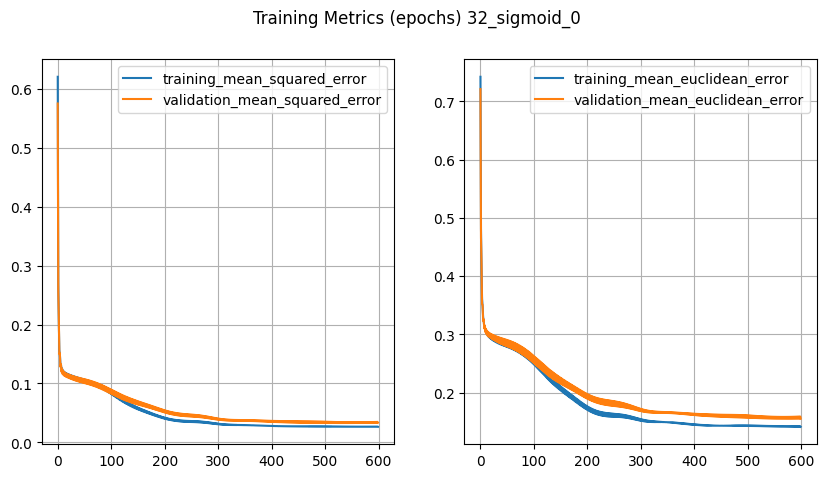

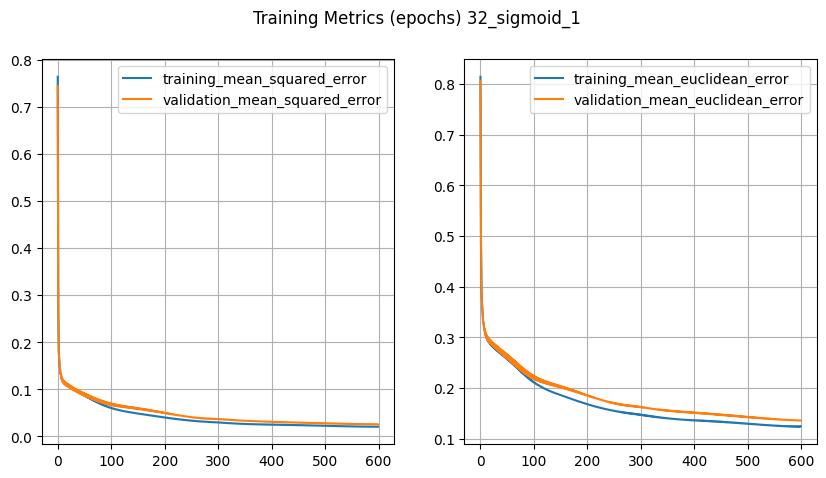

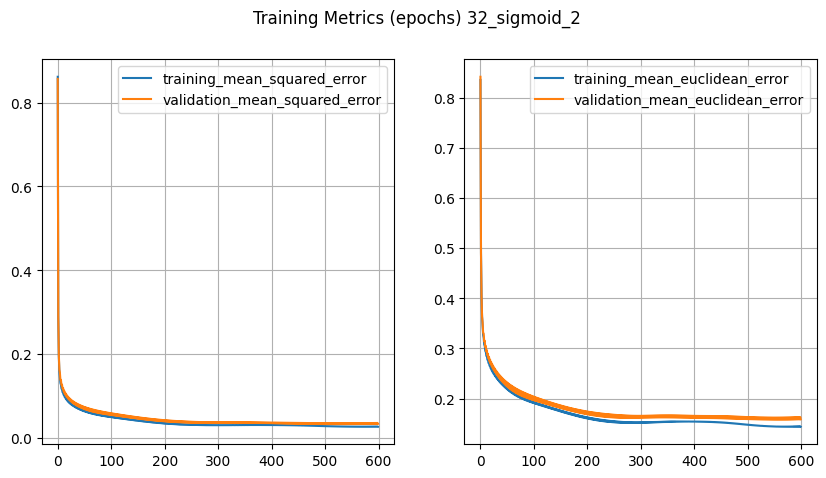

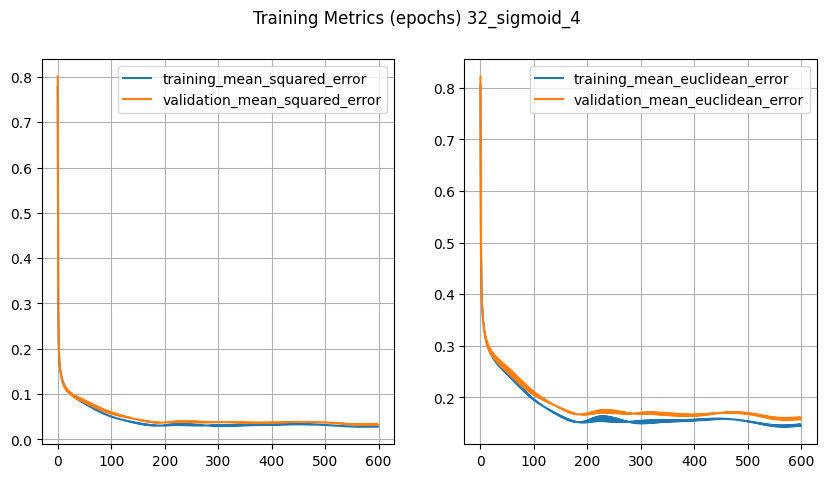

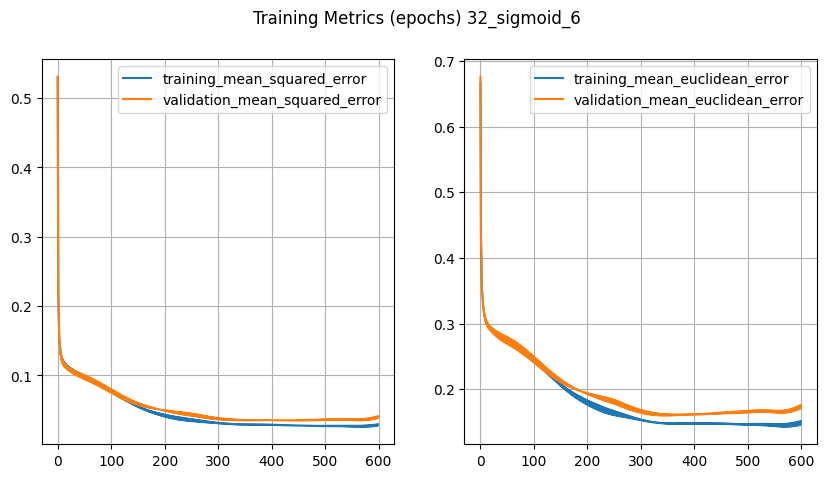

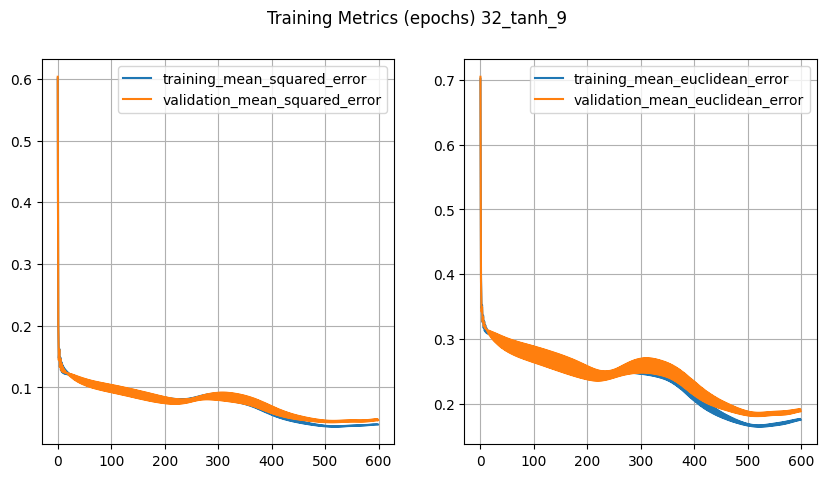

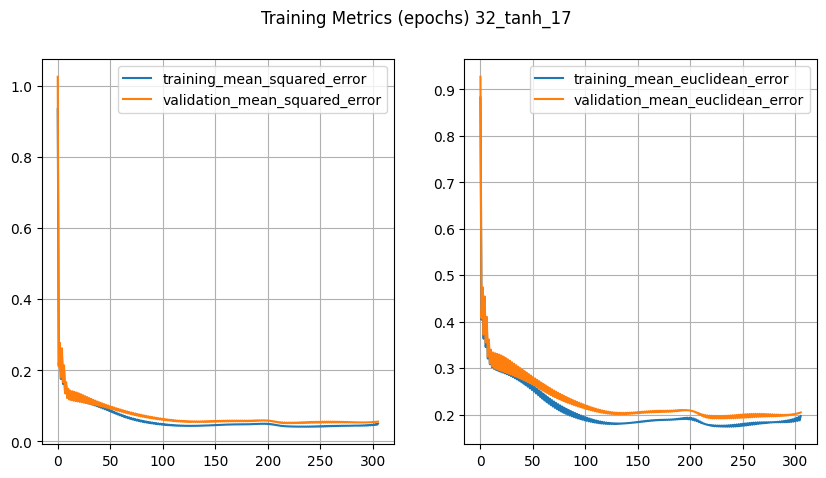

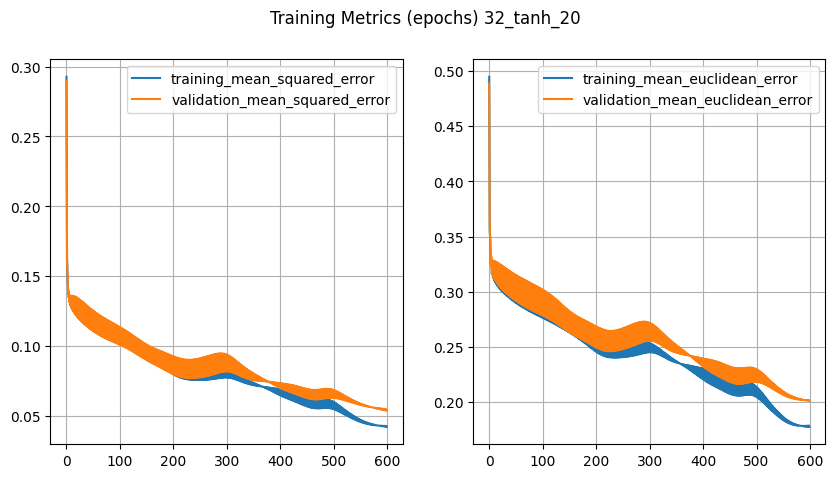

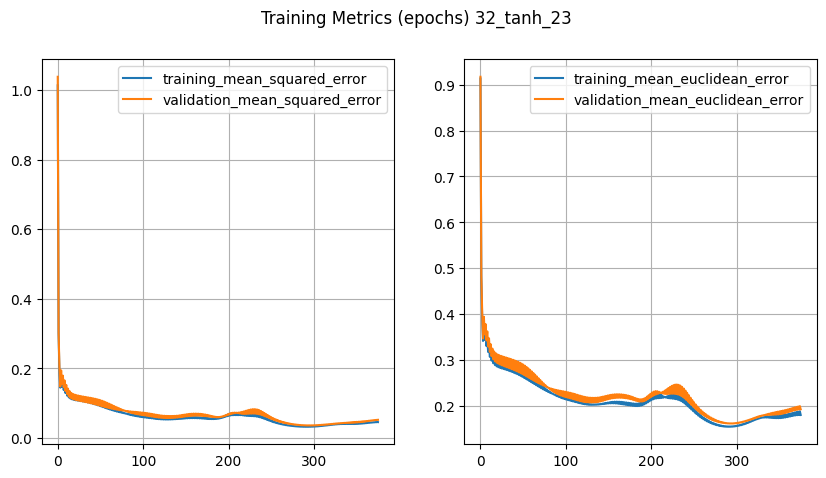

In [8]:
metrics = [ErrorFunctions.mean_squared_error, ErrorFunctions.mean_euclidean_error]
for dummy in interesting_model:
    stats = dummy['stats']
    fig, ax = plt.subplots(1, len(metrics), figsize=(10, 5))
    plt.suptitle('Training Metrics (epochs) ' + dummy['top_name'] + '_' + str(dummy['index']))
    for i in range(len(metrics)):
        multy_plot([stats['training_' + metrics[i].__name__], stats['validation_' + metrics[i].__name__]], 
                ['training_' + metrics[i].__name__, 'validation_' + metrics[i].__name__],
                ax=ax[i])

In [11]:
dic_list = []
for dummy in interesting_model:
    dic = {}
    dic[dummy['top_name'] + 'tmse'] = dummy['stats']['training_mean_squared_error']
    dic[dummy['top_name'] + 'vmse'] = dummy['stats']['validation_mean_squared_error']
    dic[dummy['top_name'] + 'tmee'] = dummy['stats']['training_mean_euclidean_error']
    dic[dummy['top_name'] + 'vmee'] = dummy['stats']['validation_mean_euclidean_error']
    dic_list.append(pd.DataFrame(dic))
    
for i in dic_list:
    fig = px.line(i)
    fig.show()